In [1]:
# python -u train.py ETTh1 forecast_multivar --archive forecast_csv --repr-dims 320 --gpu 0 --seed 42 --eval
# python -u train.py BME classification --archive UCR --repr-dims 320 --gpu 0 --seed 42 --eval
import numpy as np
import datautils
from ts2vec import TS2Vec
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

In [3]:
def generate_pred_samples(features, data, pred_len, drop=0):
    n = data.shape[1]
    features = features[:, :-pred_len]
    labels = np.stack([ data[:, i:1+n+i-pred_len] for i in range(pred_len)], axis=2)[:, 1:]
    features = features[:, drop:]
    labels = labels[:, drop:]
    return features.reshape(-1, features.shape[-1]), \
            labels.reshape(-1, labels.shape[2]*labels.shape[3])

def cal_metrics(pred, target):
    return {
        'MSE': ((pred - target) ** 2).mean(),
        'MAE': np.abs(pred - target).mean()
    }

data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols = datautils.load_forecast_csv('ETTh1')

model = TS2Vec(
    input_dims=data.shape[-1],
    device='cpu',
    output_dims=320
)

model.load('datasets/model.pkl')
all_repr = model.encode(
    data,
    casual=True,
    sliding_length=1,
    sliding_padding=200,
    batch_size=256
)

In [4]:
train_repr = all_repr[:, train_slice]
valid_repr = all_repr[:, valid_slice]
test_repr = all_repr[:, test_slice]
    
train_data = data[:, train_slice, n_covariate_cols:]
valid_data = data[:, valid_slice, n_covariate_cols:]
test_data = data[:, test_slice, n_covariate_cols:]

pred_len = 48
train_features, train_labels = generate_pred_samples(train_repr, train_data, pred_len, drop=200)
test_features, test_labels = generate_pred_samples(test_repr, test_data, pred_len)

In [6]:
clf = Ridge(alpha=0.1).fit(train_features, train_labels)
pred = clf.predict(test_features)
cal_metrics(pred, test_labels)

{'MSE': 0.6280464242618345, 'MAE': 0.5592593614692188}

{'MSE': 3.825295092738031, 'MAE': 1.3755364707068791}


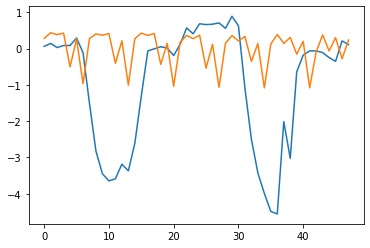

In [17]:
print(cal_metrics(pred[0][:48], test_data.reshape(-1, test_data.shape[2])[:,0][1:1+pred_len]))
plt.plot(test_data.reshape(-1, test_data.shape[2])[:,0][1:1+pred_len])
plt.plot(pred[0][:48])
plt.show()